# Diseño de una red clasificación

## CNN para la clasificación de tipos de cartas de Naipe como tarea de entretenimiento

Se presenta una arquitectura de red neuronal híbrida, que cuenta con capas de red convolucionales desde la entrada hasta cierta capa oculta y se conectan con capas Fully Connected en las últimas capas ocultas, junto con la capa de salida para realizar una clasificación de diferentes tipos de cartas de Naipe.

La presente aplicación tiene un sentido netamente de entretenimiento. Pero se consideró una oportunidad divertida para solucionar este caso de clasificación.

#### Cargue de librerías

In [1]:
import torch
import numpy as np 
from torchvision import datasets, models
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from collections import OrderedDict

c:\Users\comunicaciones\Anaconda3\envs\radeon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Lectura de GPU

In [2]:
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print('CUDA disponible. Entrenamiento en GPU.')
else:
    print('CUDA no disponible. Entrenamiento en CPU.')

CUDA no disponible. Entrenamiento en CPU.


#### Definicón del directorio de las imágenes a utilizar y cargue de las misma

En esta sección se realiza la configuración para aplicar DataAugmentatios al set de datos elegido. Como transformaciones a aplicar, se eligieron: Dar la vuelta a la foto de forma aleatoria horizontalmente (RandomHorizontalFlip), hacer una rotación de 20° aleatoriamente (transforms.RandomRotation(20)). Lo anterior para el set de datos de entrenamiento y validación y para prueba se cambión la rotación aleatoria por una perspectiva aleatoria (RandomPerspective), con la finalidad de aplicar tranformaciones diferentes. También realizó una normalización con algunos valores por defecto para expereminetos de media, desviación estandar de 0.5 y 0.5 respectivamente, para cada una de las capas RGB de las imágenes. En el mismo sentido, al ser requerido, se realiza un transformación a tensor de cada imagen.

Respecto al set de datos, este es un conjunto de datos de muy alta calidad de imágenes de naipes. Todas las imágenes son 224 X 224 X 3 en formato jpg. Se específico un set de datos con 6 categorias, con diferentes cantidades de imágenes (en la ejecución del código se observa la cantidad total de imágenes con la que se trabaja). Los grupos elegidos para esta aplicación fueron: ace of clubs, eight of clubs, queen of spades, seven of clubs, three of spades, two of clubs.

In [3]:
# Ruta de las imágenes:
data_dir_train = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/archive/train"
data_dir_val = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/archive/valid"
data_dir_test = "C:/Users/comunicaciones/Documents/johan/Maestria/Aprendizaje profundo/Taller 2/archive/test"

# Tamaño de los batches:
batch_size = 20
# Cantidad de clases a aplicar:
classes = 6

# Definición de las trannsformaciones a aplicar al set de datos:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomRotation(20),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(), # randomly flip and rotate
    transforms.RandomPerspective(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

# Se leen las imágenes:
train_data = datasets.ImageFolder(data_dir_train, transform = transform_train)
val_data = datasets.ImageFolder(data_dir_val, transform = transform_train)
test_data = datasets.ImageFolder(data_dir_test, transform = transform_test)

num_train = len(train_data)
print(f'Cantidad de imágenes para entrenamiento: {num_train}')
num_val = len(val_data)
print(f'Cantidad de imágenes para validación: {num_val}')
num_test = len(test_data)
print(f'Cantidad de imágenes para prueba: {num_test}')
indices_train = list(range(num_train))
indices_val = list(range(num_val))
np.random.shuffle(indices_train)
np.random.shuffle(indices_val)
train_idx, valid_idx = indices_train, indices_val
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Cargue de los Dataloader correspondientes:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = num_test) # El grupo de prueba no se divide en batches.

# Etiquetas de los grupos a clasificar:
classes = ['ace of clubs', 'eight of clubs', 'queen of spades', 'seven of clubs', 'three of spades', 'two of clubs']

Cantidad de imágenes para entrenamiento: 800
Cantidad de imágenes para validación: 30
Cantidad de imágenes para prueba: 30


#### Visualización de algunas imágenes

Se muestran las imagenes correspondientes a un batch. Se evidencian algunos giros aleatorios de las imágenes aplicadas en el DataAugmentation.

c:\Users\comunicaciones\Anaconda3\envs\radeon\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


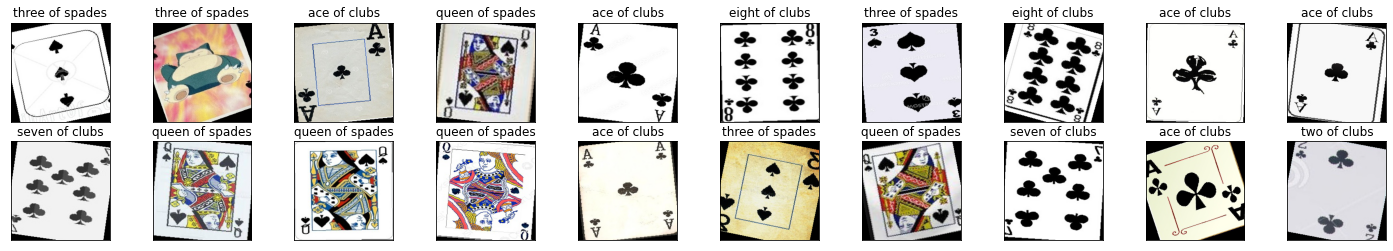

In [4]:
def imshow(img):
    img = img / 2 + 0.5  # Desnormalización.
    plt.imshow(np.transpose(img, (1, 2, 0)))  # Se convierte de tensor a imagen

dataiter = iter(train_loader)
images, labels = dataiter.next()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### Arquitectura de la red 

Se define una arquitectura de red neuronal con 5 capas convolucionales, seguidas por capas de Max Pooling y de una arquitectura Fully Connected de 3 capas, seguida de Dropout con un porcentaje del 20 % de desactivación aleatoria de las neuronas. El resumen de la arquitectura definida se puede observar en secciones posteriores.

In [5]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # prof, 224, 224
        self.conv_in = nn.Conv2d(3, 16, 3, padding = 1) # prof, 112, 112
        self.conv1 = nn.Conv2d(16, 32, 3, padding = 1) # prof, 56, 56
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1) # prof, 28, 28
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1) # prof, 14, 14
        self.conv4 = nn.Conv2d(128, 256, 3, padding = 1) # prof, 7, 7
        self.pool = nn.MaxPool2d(2, 2) 
        self.fc1 = nn.Linear(256 * 7 * 7, 500)
        self.fc2 = nn.Linear(500, 256)
        self.fc_out = nn.Linear(256, 6)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv_in(x))) 
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = self.pool(F.relu(self.conv3(x))) 
        x = self.pool(F.relu(self.conv4(x))) 
        x = x.view(-1, 256 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc_out(x)
        return x

model = Net()
print(model)

# Se mueve el modelo a GPU si está disponible:
if train_on_gpu:
    model.cuda()

# Resumen de la arquitectura definida:
print('Resumen de la arquitectura definida:')
summary(model, input_size=(3, 224, 224))

Net(
  (conv_in): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=12544, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=256, bias=True)
  (fc_out): Linear(in_features=256, out_features=6, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Resumen de la arquitectura definida:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]          

#### Definicón de la función de costo y del optimizador

Como función de costo de configura la función 'CrossEntropyLoss' y se elige el optimizador de Adam al ser uno de los más eficientes, con una tasa de aprendizaje fijada en 1e-3 ya que esta se toma como una tasa por defecto adecuada para cualquier problema.

In [6]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

### Ciclo de entrenamiento

Se realiza el proceso de entrenamiento de la arquitectura definida para una cantidad de 50 épocas. Se almacena de la misma manera el cambio de la función de pérdida establecida, para determinar la calidad del entrenamiento, como se muestra en una sección más próxima.

In [7]:
# Número de épocas:
n_epochs = 50

# Vectores para guardar la variación de la función de pérdida:}
train_graph=[]
valid_graph=[]
accuracy_graph = []

for epoch in range(1, n_epochs+1):
    if epoch == 1:
        valid_loss_min = np.Inf # Valor inicial de la función de perdida de validación.

    # Reinicio de las funciones de pérdida:
    train_loss = 0.0
    valid_loss = 0.0
    
    #################
    # Entrenamiento #
    #################

    # Modelo en modo entrenamiento:
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        num_correct = 0
        num_total = 0

        # Se mueve el modelo a GPU:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()

        # Cálculo de los scores:
        output = model(data)

        _, pred = output.max(dim=1) #pred shape (mb_size )
        num_correct += (pred == target.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
        num_total += pred.size(0)

        # Cálculo de la función de pérdida y actualización de parámetros:
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    accuracy_graph.append(float(num_correct)/num_total)
        
    ############## 
    # validación #
    ##############
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # Media de la función de pérdida:
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_graph.append(train_loss)
    valid_graph.append(valid_loss) 
        
    # Se muestran las estadísticas:
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuraccy: {:.2f} %'.format(
        epoch, train_loss, valid_loss, 100 * (float(num_correct)/num_total)))
    
    # Se guarda el mejor modelo:
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Full_model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.557309 	Validation Loss: 1.077888 	Accuraccy: 60.00 %
Validation loss decreased (inf --> 1.077888).  Saving model ...
Epoch: 2 	Training Loss: 1.090037 	Validation Loss: 0.736308 	Accuraccy: 60.00 %
Validation loss decreased (1.077888 --> 0.736308).  Saving model ...
Epoch: 3 	Training Loss: 0.849138 	Validation Loss: 0.298275 	Accuraccy: 70.00 %
Validation loss decreased (0.736308 --> 0.298275).  Saving model ...
Epoch: 4 	Training Loss: 0.771407 	Validation Loss: 0.650650 	Accuraccy: 75.00 %
Epoch: 5 	Training Loss: 0.681042 	Validation Loss: 0.287602 	Accuraccy: 80.00 %
Validation loss decreased (0.298275 --> 0.287602).  Saving model ...
Epoch: 6 	Training Loss: 0.633388 	Validation Loss: 0.293997 	Accuraccy: 80.00 %
Epoch: 7 	Training Loss: 0.620105 	Validation Loss: 0.291357 	Accuraccy: 85.00 %
Epoch: 8 	Training Loss: 0.543588 	Validation Loss: 0.110391 	Accuraccy: 95.00 %
Validation loss decreased (0.287602 --> 0.110391).  Saving model ...
Epoch: 9 	Tr

#### Visualización de la variación de la funciones de pérdida para los datos de entrenamiento y validación y del Accuraccy durante el entrenamiento.

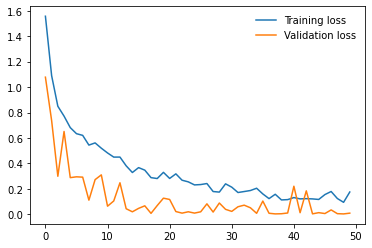

In [8]:
plt.plot(train_graph, label='Training loss')
plt.plot(valid_graph, label='Validation loss')
plt.legend(frameon=False)

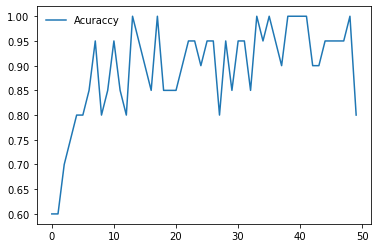

In [9]:
plt.plot(accuracy_graph, label= 'Acuraccy')
plt.legend(frameon=False)

Se evidencia que el entrenamiento se ejecutó de forma correcta. En el mismo sentido, graficamente se observa que el modelo no presenta underfitting ni overfitting. Este se ajusta de forma generalizada frente a los datos escogidos y se logra un accuraccy alto.

#### Cargue del mejor modelo obtenido

Se lee el mejor modelo que se obtuvo en el entrenamiento.

In [10]:
model.load_state_dict(torch.load('Full_model.pt'))

<All keys matched successfully>

#### Prueba del modelo obtenido

In [11]:
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

# Modelo en modo de validación:
model.eval()

# (Función similar adecuada desde la función previa del entrenamiento.)
data, target = next(iter(test_loader))
if train_on_gpu:
    data, target = data.cuda(), target.cuda()
output = model(data)
loss = criterion(output, target)
test_loss += loss.item()*data.size(0)
_, pred = torch.max(output, 1)    
correct_tensor = pred.eq(target.data.view_as(pred))
correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
for i in range(len(test_data)):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# Se muestran algunas métricas:
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy de %5s: N/A' % (classes[i]))

print('\nTest Accuracy (General): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.205197

Test Accuracy de ace of clubs: 80% ( 4/ 5)
Test Accuracy de eight of clubs: 100% ( 5/ 5)
Test Accuracy de queen of spades: 100% ( 5/ 5)
Test Accuracy de seven of clubs: 80% ( 4/ 5)
Test Accuracy de three of spades: 80% ( 4/ 5)
Test Accuracy de two of clubs: 60% ( 3/ 5)

Test Accuracy (General): 83% (25/30)


Se evidencia que para cada una de las categorias a clasificar, con los datos de prueba obtiene un accuraccy adecuado para la cantidad de datos establecida.

#### Visualización de algunas las imágenes de prueba, con su respectiva etiqueta obtenida

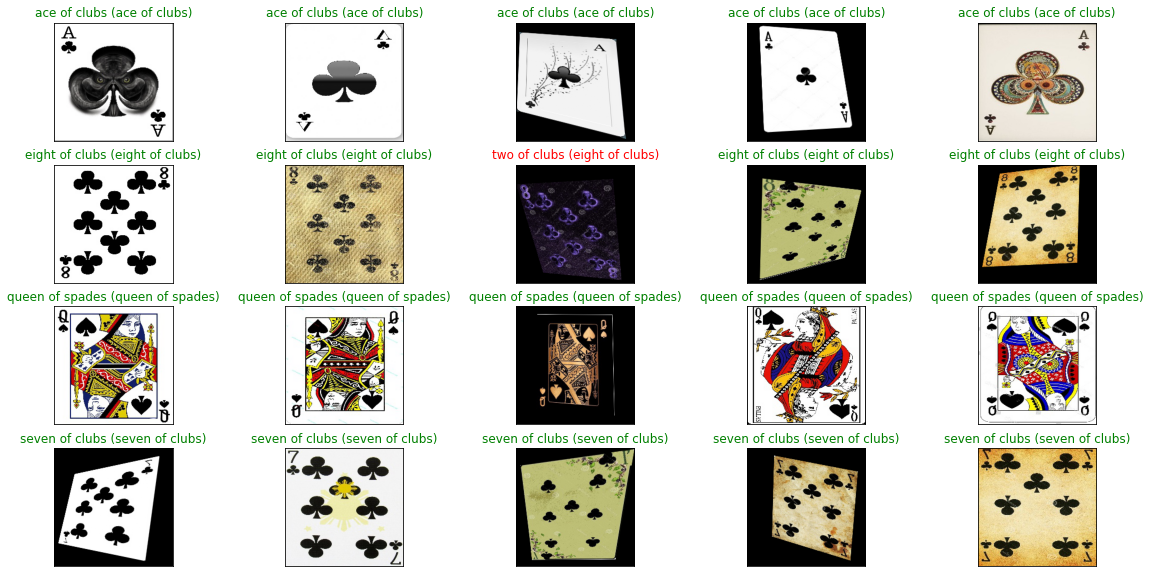

In [12]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize = (20, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))

Se observa que para las imágenes mostradas las etiquetas corresponden de forma correcta a su etiqueta original en su gran mayoria.

# _____________________________________________________________________________________________________________________________________

# Clasificación usando Transfer Learning

A continuación, se realiza una solución a la misma aplicación descrita previamente, ejecutando una gran parte de lo realizado hasta el momento, pero utilizando transferencia de aprendizaje para la misma. Se utiliza el modelo preentrenado AlexNet y se modifican algunas capas requeridas como las de salida para clasificar las categorias eespecíficas.

Se muestra la arquitectura de la red AlexNet.

In [13]:
model = models.densenet121(pretrained = True)

Se modifica la última capa correspondiente a la clasificación, para que se ajuste a la aplicación de la clasificación de diferentes tipos de cartas de Naipe.
La nueva arquitectura de la capa de salida se establece de tal forma que la cantidad de neuronas vaya disminuyendo en potencia de 2 para no tener cambios tan drasticos en dicha arquitectura.

In [14]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = nn.Sequential(nn.Linear(1024, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 256),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(256, 128),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(128, 64),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(64, 32),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(32, 16),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(16, 8),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(8, 6)
                                )

Se repiten ahora los procedimientos ejecutados en la sección previa para realizar el entrenamiento y validación del modelo mismo. Como se muestra en las secciones siguientes.

In [15]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

# Ciclo de entrenamiento

In [16]:
# Vectores para guardar la variación de la función de pérdida:}
train_graph=[]
valid_graph=[]
accuracy_graph = []

for epoch in range(1, n_epochs+1):
    if epoch == 1:
        valid_loss_min = np.Inf # Valor inicial de la función de perdida de validación.

    # Reinicio de las funciones de pérdida:
    train_loss = 0.0
    valid_loss = 0.0
    
    #################
    # Entrenamiento #
    #################

    # Modelo en modo entrenamiento:
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        num_correct = 0
        num_total = 0

        # Se mueve el modelo a GPU:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()

        # Cálculo de los scores:
        output = model(data)

        _, pred = output.max(dim=1) #pred shape (mb_size )
        num_correct += (pred == target.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
        num_total += pred.size(0)

        # Cálculo de la función de pérdida y actualización de parámetros:
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    accuracy_graph.append(float(num_correct)/num_total)
        
    ############## 
    # validación #
    ##############
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # Media de la función de pérdida:
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_graph.append(train_loss)
    valid_graph.append(valid_loss) 
        
    # Se muestran las estadísticas:
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuraccy: {:.2f} %'.format(
        epoch, train_loss, valid_loss, 100 * (float(num_correct)/num_total)))
    
    # Se guarda el mejor modelo:
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Full_model_transfer.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.795868 	Validation Loss: 1.987666 	Accuraccy: 10.00 %
Validation loss decreased (inf --> 1.987666).  Saving model ...
Epoch: 2 	Training Loss: 1.776797 	Validation Loss: 1.633013 	Accuraccy: 50.00 %
Validation loss decreased (1.987666 --> 1.633013).  Saving model ...
Epoch: 3 	Training Loss: 1.663964 	Validation Loss: 1.814230 	Accuraccy: 20.00 %
Epoch: 4 	Training Loss: 1.563065 	Validation Loss: 1.135564 	Accuraccy: 5.00 %
Validation loss decreased (1.633013 --> 1.135564).  Saving model ...
Epoch: 5 	Training Loss: 1.490757 	Validation Loss: 1.493305 	Accuraccy: 25.00 %
Epoch: 6 	Training Loss: 1.467344 	Validation Loss: 1.224145 	Accuraccy: 40.00 %
Epoch: 7 	Training Loss: 1.400322 	Validation Loss: 0.851614 	Accuraccy: 60.00 %
Validation loss decreased (1.135564 --> 0.851614).  Saving model ...
Epoch: 8 	Training Loss: 1.397768 	Validation Loss: 1.185578 	Accuraccy: 50.00 %
Epoch: 9 	Training Loss: 1.357264 	Validation Loss: 1.078537 	Accuraccy: 65.00 %
E

#### Visualización de la variación de la funciones de pérdida para los datos de entrenamiento y validación y del Accuraccy durante el entrenamiento.

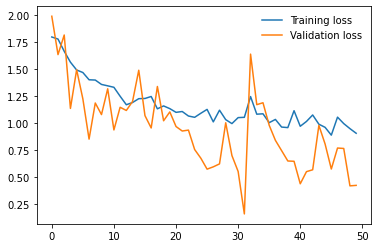

In [17]:
plt.plot(train_graph, label='Training loss')
plt.plot(valid_graph, label='Validation loss')
plt.legend(frameon=False)

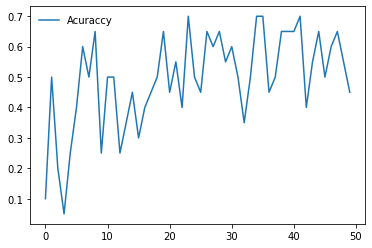

In [18]:
plt.plot(accuracy_graph, label= 'Acuraccy')
plt.legend(frameon=False)

#### Cargue del mejor modelo

In [19]:
model.load_state_dict(torch.load('Full_model_transfer.pt'))

<All keys matched successfully>

#### Prueba del modelo obtenido

In [20]:
test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

# Modelo en modo de validación:
model.eval()

# (Función similar adecuada desde la función previa del entrenamiento.)
data, target = next(iter(test_loader))
if train_on_gpu:
    data, target = data.cuda(), target.cuda()
output = model(data)
loss = criterion(output, target)
test_loss += loss.item()*data.size(0)
_, pred = torch.max(output, 1)    
correct_tensor = pred.eq(target.data.view_as(pred))
correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
for i in range(len(test_data)):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# Se muestran algunas métricas:
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy de %5s: N/A' % (classes[i]))

print('\nTest Accuracy (General): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.175271

Test Accuracy de ace of clubs: 80% ( 4/ 5)
Test Accuracy de eight of clubs: 60% ( 3/ 5)
Test Accuracy de queen of spades: 100% ( 5/ 5)
Test Accuracy de seven of clubs:  0% ( 0/ 5)
Test Accuracy de three of spades: 40% ( 2/ 5)
Test Accuracy de two of clubs:  0% ( 0/ 5)

Test Accuracy (General): 46% (14/30)


#### Visualización de algunas las imágenes de prueba, con su respectiva etiqueta obtenida

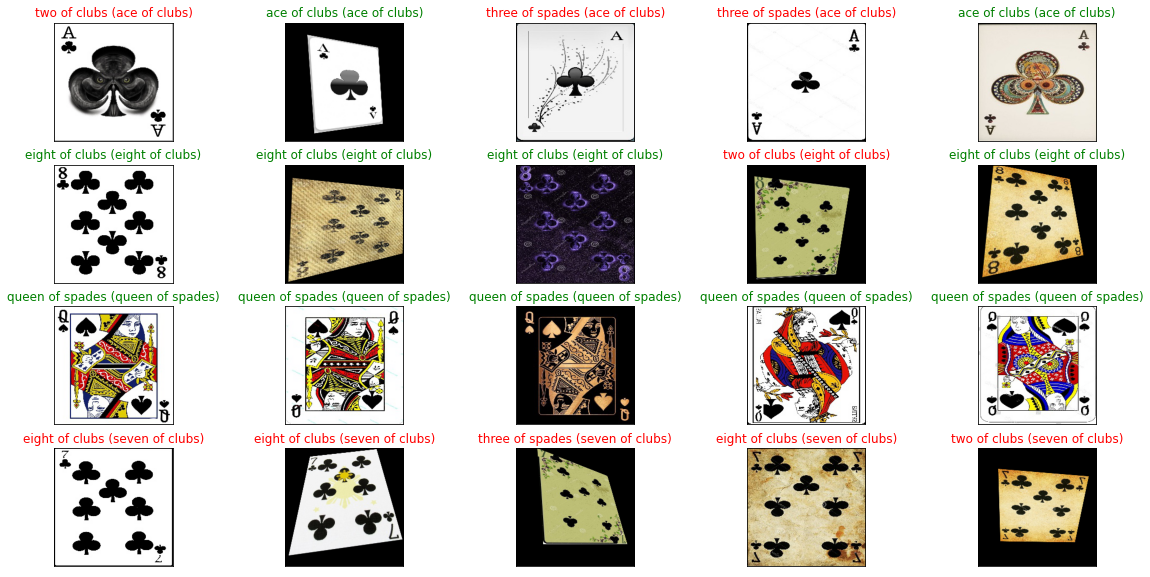

In [21]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig = plt.figure(figsize = (20, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                color=("green" if preds[idx]==labels[idx].item() else "red"))